In [1]:
import numpy as np
import pandas as pd
import requests as req
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings('ignore')

Containment Date Time: The date and time a wildfire was declared contained. 

Control Date Time: The date and time a wildfire was declared under control.

Daily Acres: A measure of acres reported for a fire.  More specifically, the number of acres within the current perimeter of a specific, individual incident, including unburned and unburnable islands.  The minimum size must be 0.1.

Discovery Acres: An estimate of acres burning upon the discovery of the fire. More specifically when the fire is first reported by the first person that calls in the fire.  The estimate should include number of acres within the current perimeter of a specific, individual incident, including unburned and unburnable islands.

Predominant Fuel Model: Describes the type of fuels found within the  majority of the incident area.

In [2]:
# load data
#pd.options.display.max_columns = None
fires_original = pd.read_csv("WFIGS_-_Wildland_Fire_Locations_Full_History.csv")
fires_original = fires_original[['ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','POOState','PredominantFuelModel','FireCauseGeneral','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude']]
fires_original.describe()

,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude
count,1.444240e+05,151655.000000,152050.000000,152050.000000
mean,5.036945e+02,21.396285,39.849125,-111.687900
std,8.527152e+03,907.979758,12.101975,42.324323
min,0.000000e+00,0.000000,-1764.783333,-10149.766667
25%,1.000000e-01,0.100000,34.492074,-118.543990
50%,3.000000e-01,0.100000,38.895331,-114.215067
75%,5.000000e+00,1.000000,44.243015,-106.974425
max,1.032648e+06,250000.000000,3549.602000,190.850000


In [3]:
# consider if dropna first makes any difference to mean or median value
fires_dis = fires_original.dropna(subset = ['DiscoveryAcres'])
fires_dis['DiscoveryAcres'].describe()

count    151655.000000
mean         21.396285
std         907.979758
min           0.000000
25%           0.100000
50%           0.100000
75%           1.000000
max      250000.000000
Name: DiscoveryAcres, dtype: float64

In [4]:
# check if there's any unformat datetime
fires_original['CorrectControlDateTime'] = pd.to_datetime(fires_original['ControlDateTime'],errors='coerce')
errors = fires_original.loc[fires_original['CorrectControlDateTime'].isnull()]['ControlDateTime'].unique().tolist()
errors

[nan,
 '0214/08/14 21:34:00+00',
 '0214/08/05 07:00:00+00',
 '1159/10/22 17:00:00+00']

In [5]:
correct_dict = {'0214/08/14 21:34:00+00' : '2014/08/14 21:34:00+00',
                '0214/08/05 07:00:00+00' : '2014/08/05 07:00:00+00',
                '1159/10/22 17:00:00+00' : '2014/08/03 17:00:00+00'}
fires_original['ControlDateTime'] = fires_original['CorrectControlDateTime'].fillna(pd.to_datetime(fires_original['ControlDateTime'].map(correct_dict)))


In [6]:
#convert DATETIME columns to datetime formula
fires_original['YEAR'] = pd.to_datetime(fires_original['FireDiscoveryDateTime']).dt.year
fires_original['DiscoveryDate'] = pd.to_datetime(fires_original['FireDiscoveryDateTime']).dt.date
fires_original['FireDiscoveryDateTime']=pd.to_datetime(fires_original['FireDiscoveryDateTime'], format="%Y-%m-%d %H:%M:%S")
fires_original['ControlDateTime']=pd.to_datetime(fires_original['ControlDateTime'], format="%Y-%m-%d %H:%M:%S")
fires_original.head()

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,PredominantFuelModel,FireCauseGeneral,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude,CorrectControlDateTime,YEAR,DiscoveryDate
0,2020-08-06 23:13:24+00:00,2020/08/06 23:13:07+00,2020-08-06 18:58:00+00:00,US-MT,GR4,Equipment,50.6,20.0,45.78496,-104.4958,2020-08-06 23:13:24+00:00,2020,2020-08-06
1,NaT,NaN,2020-02-28 20:45:40+00:00,US-CA,NaN,NaN,NaN,0.1,33.80898,-118.1807,NaT,2020,2020-02-28
2,2017-10-18 00:35:00+00:00,2017/10/18 00:30:00+00,2017-10-17 20:20:24+00:00,US-MT,NaN,NaN,50.0,50.0,48.07167,-114.8303,2017-10-18 00:35:00+00:00,2017,2017-10-17
3,NaT,NaN,2019-07-01 19:54:00+00:00,US-CA,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2019,2019-07-01
4,NaT,NaN,2016-06-20 22:05:59+00:00,US-CA,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2016,2016-06-20


In [7]:
#add a column to calculate how long the fire was burning
fires_original["Fire_Duration"]=(fires_original['ControlDateTime'] - fires_original['FireDiscoveryDateTime'])/pd.Timedelta(hours=1)
fires_original

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,PredominantFuelModel,FireCauseGeneral,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude,CorrectControlDateTime,YEAR,DiscoveryDate,Fire_Duration
0,2020-08-06 23:13:24+00:00,2020/08/06 23:13:07+00,2020-08-06 18:58:00+00:00,US-MT,GR4,Equipment,50.6,20.0,45.784960,-104.495800,2020-08-06 23:13:24+00:00,2020,2020-08-06,4.256667
1,NaT,NaN,2020-02-28 20:45:40+00:00,US-CA,NaN,NaN,NaN,0.1,33.808980,-118.180700,NaT,2020,2020-02-28,NaN
2,2017-10-18 00:35:00+00:00,2017/10/18 00:30:00+00,2017-10-17 20:20:24+00:00,US-MT,NaN,NaN,50.0,50.0,48.071670,-114.830300,2017-10-18 00:35:00+00:00,2017,2017-10-17,4.243333
3,NaT,NaN,2019-07-01 19:54:00+00:00,US-CA,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2019,2019-07-01,NaN
4,NaT,NaN,2016-06-20 22:05:59+00:00,US-CA,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2016,2016-06-20,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211532,NaT,NaN,2022-03-14 19:46:52+00:00,US-CA,NaN,NaN,NaN,0.1,38.404329,-120.454859,NaT,2022,2022-03-14,NaN
211533,NaT,NaN,2022-03-14 18:52:51+00:00,US-TX,NaN,Undetermined,10.0,30.0,31.189829,-97.951463,NaT,2022,2022-03-14,NaN
211534,NaT,2022/03/14 15:59:59+00,2022-03-13 20:15:00+00:00,US-OK,NaN,NaN,3.4,3.4,35.358830,-96.185750,NaT,2022,2022-03-13,NaN
211535,NaT,NaN,2022-03-14 19:39:15+00:00,US-TX,NaN,Undetermined,5.0,5.0,33.021967,-94.564750,NaT,2022,2022-03-14,NaN


In [8]:
fires_original.FireCauseGeneral.unique()

array(['Equipment', nan, 'Incendiary', 'Lightning', 'Debris/Open Burning',
       'Camping', 'Investigated but Undetermined', 'Other Human Cause',
       'Misc/Other', 'Cause and Origin Not Identified',
       'Firearms/Weapons', 'Other Natural Cause', 'Natural', 'Utilities',
       'Smoking', 'Debris Burning (Fire Use)', 'Coal Seam', 'Railroad',
       'Undetermined'], dtype=object)

In [9]:
# General Fire Cause to numerica values
fires_original['FireCauseGeneral'] = fires_original['FireCauseGeneral'].replace(['Incendiary','Other Human Cause','Debris/Open Burning','Equipment','Camping','Utilities','Firearms/Weapons','Investigated but Undetermined',
                                                                                 'Cause and Origin Not Identified','Coal Seam','Railroad','Smoking','Debris Burning (Fire Use)'],'1')
fires_original['FireCauseGeneral'] = fires_original['FireCauseGeneral'].replace(['Lightning','Other Natural Cause', 'Natural'],'2')
fires_original['FireCauseGeneral'] = fires_original['FireCauseGeneral'].replace(['Undetermined','Misc/Other', 'nan'],'3')

# Legend For General Cause
# 1 = Human
# 2 = Nature
# 3 = Uncategorized


In [10]:
# Import LE to convert Fuel Model and General Cause to Numeric Values
from sklearn.preprocessing import LabelEncoder

# Converting Fuel Model to Numeric and using Label encoders for this 
label_encoder = LabelEncoder()
fires_original["fueltype_num"] = label_encoder.fit_transform(fires_original["PredominantFuelModel"])

In [11]:
# fillna with mean/min values or dropna values; fillna datetime from another column

fires_original['ControlDateTime'].fillna(fires_original['ContainmentDateTime'], inplace=True)
#fires['ControlDateTime'].fillna(fires['FireDiscoveryDateTime'], inplace=True)
fires_da_mean = pd.DataFrame(fires_original).fillna(fires_original['DiscoveryAcres'].mean())
fires_da_median = pd.DataFrame(fires_original).fillna({'DiscoveryAcres': 0.1})
fires_da_drop = pd.DataFrame(fires_original).dropna(subset = ['DiscoveryAcres'])
#fires['DailyAcres'].fillna(0.1, inplace=True)
#fires_original.isnull().sum()

# Fire Severity base on Discovery Acres (fill na with mean value)

In [12]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires (fillna with mean value)
fires_da_mean.loc[fires_da_mean['DiscoveryAcres'] <= .25, 'fire_severity'] = 1
fires_da_mean.loc[(fires_da_mean['DiscoveryAcres'] > .25) & (fires_da_mean['DiscoveryAcres'] <= 10), 'fire_severity'] = 2
fires_da_mean.loc[(fires_da_mean['DiscoveryAcres'] > 10) & (fires_da_mean['DiscoveryAcres'] <= 100), 'fire_severity'] = 3
fires_da_mean.loc[(fires_da_mean['DiscoveryAcres'] > 100) & (fires_da_mean['DiscoveryAcres'] <= 300), 'fire_severity'] = 4
fires_da_mean.loc[(fires_da_mean['DiscoveryAcres'] > 300) & (fires_da_mean['DiscoveryAcres'] <= 1000), 'fire_severity'] = 5
fires_da_mean.loc[(fires_da_mean['DiscoveryAcres'] > 1000) & (fires_da_mean['DiscoveryAcres'] <= 5000), 'fire_severity'] = 6
fires_da_mean.loc[fires_da_mean['DiscoveryAcres'] > 5000, 'fire_severity'] = 7          
print(fires_da_mean['fire_severity'].value_counts())

1.0    97131
3.0    66427
2.0    45336
4.0     1282
5.0      926
6.0      381
7.0       54
Name: fire_severity, dtype: int64


In [13]:
fires_da_mean.head()

,ControlDateTime,ContainmentDateTime,FireDiscoveryDateTime,POOState,PredominantFuelModel,FireCauseGeneral,DailyAcres,DiscoveryAcres,InitialLatitude,InitialLongitude,CorrectControlDateTime,YEAR,DiscoveryDate,Fire_Duration,fueltype_num,fire_severity
0,2020-08-06 23:13:24+00:00,2020/08/06 23:13:07+00,2020-08-06 18:58:00+00:00,US-MT,GR4,1,50.600000,20.000000,45.784960,-104.495800,2020-08-06 23:13:24+00:00,2020,2020-08-06,4.256667,3,3.0
1,21.396285,21.396285,2020-02-28 20:45:40+00:00,US-CA,21.396285,21.396285,21.396285,0.100000,33.808980,-118.180700,21.396285,2020,2020-02-28,21.396285,42,1.0
2,2017-10-18 00:35:00+00:00,2017/10/18 00:30:00+00,2017-10-17 20:20:24+00:00,US-MT,21.396285,21.396285,50.000000,50.000000,48.071670,-114.830300,2017-10-18 00:35:00+00:00,2017,2017-10-17,4.243333,42,3.0
3,21.396285,21.396285,2019-07-01 19:54:00+00:00,US-CA,21.396285,21.396285,21.396285,21.396285,21.396285,21.396285,21.396285,2019,2019-07-01,21.396285,42,3.0
4,21.396285,21.396285,2016-06-20 22:05:59+00:00,US-CA,21.396285,21.396285,21.396285,21.396285,21.396285,21.396285,21.396285,2016,2016-06-20,21.396285,42,3.0


<AxesSubplot:title={'center':'Severity (class)'}>

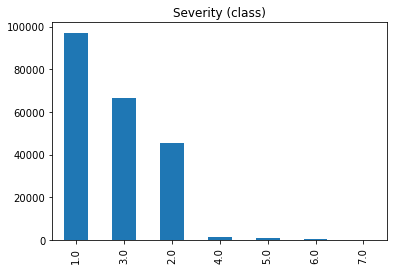

In [14]:
severity_count = fires_da_mean.fire_severity.value_counts()
severity_count.plot(kind='bar', title='Severity (class)')

In [15]:
fires_binary_encoded_mean = pd.get_dummies(fires_da_mean, columns=["PredominantFuelModel", "FireCauseGeneral"])

fires_binary_encoded_mean = fires_binary_encoded_mean.drop(['fueltype_num','CorrectControlDateTime','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude','YEAR','DiscoveryDate','POOState','Fire_Duration'], axis=1)


In [16]:
# Define the features set.
X_mean = fires_binary_encoded_mean
X_mean = X_mean.drop(["fire_severity"], axis=1)
X_mean.head()

,PredominantFuelModel_21.396284975138215,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,...,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_21.396284975138215,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
# Define the target set.
y_mean = fires_binary_encoded_mean["fire_severity"].ravel()
y_mean[:5]

array([3., 1., 3., 3., 3.])

In [18]:
# Splitting into Train and Test sets.
X_mean_train, X_mean_test, y_mean_train, y_mean_test = train_test_split(X_mean, y_mean, random_state=0)

In [19]:
#No Imbalance Handling with RandomFroestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score


#Define model
model_ori = RandomForestClassifier()

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv_ori=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores_ori = cross_validate(model_ori, X_mean, y_mean, scoring=scoring, cv=cv_ori, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_ori['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_ori['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_ori['test_recall_macro']))


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedM

Mean Accuracy: 0.4965
Mean Precision: 0.2159
Mean Recall: 0.1711


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score with mean: 0.49802401437080457
RandomForestClassification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.50      0.91      0.64     24464
         2.0       0.45      0.12      0.19     11325
         3.0       0.54      0.17      0.25     16446
         4.0       0.00      0.00      0.00       324
         5.0       0.00      0.00      0.00       211
         6.0       0.00      0.00      0.00       104
         7.0       0.00      0.00      0.00        11

    accuracy                           0.50     52885
   macro avg       0.21      0.17      0.16     52885
weighted avg       0.49      0.50      0.42     52885



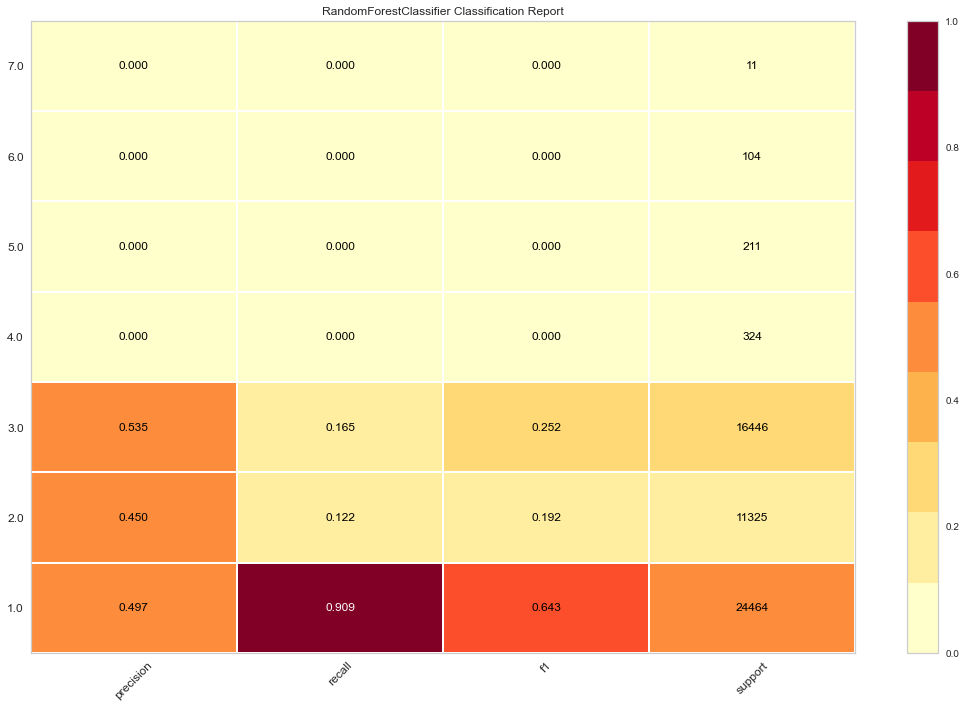

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [20]:
from yellowbrick.classifier import ClassificationReport

# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=0) 

# Fitting the model
rf_mean_model = rf_model.fit(X_mean_train, y_mean_train)
y_rfmean_pred = rf_model.predict(X_mean_test)

rf_accuracy = accuracy_score(y_mean_test, y_rfmean_pred)
print(f"Accuracy Score with mean: {rf_accuracy}")
print("RandomForestClassification Report fillna with mean")
print(classification_report(y_mean_test, y_rfmean_pred))

visualizer = ClassificationReport(
    rf_model, classes=rf_mean_model.classes_, support=True, size=(1080, 720)
)

visualizer.fit(X_mean_train, y_mean_train)  # Fit the visualizer and the model
visualizer.score(X_mean_test, y_mean_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

In [21]:
##No Imbalance Handling with LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score


#Define model
model_ori = LogisticRegression(solver='lbfgs',max_iter=100)

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv_ori=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores_ori = cross_validate(model_ori, X_mean, y_mean, scoring=scoring, cv=cv_ori, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_ori['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_ori['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_ori['test_recall_macro']))


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

Mean Accuracy: 0.4962
Mean Precision: 0.2135
Mean Recall: 0.1697


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score with mean: 0.4988181904131606
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.50      0.92      0.65     24464
         2.0       0.46      0.11      0.17     11325
         3.0       0.54      0.16      0.25     16446
         4.0       0.00      0.00      0.00       324
         5.0       0.00      0.00      0.00       211
         6.0       0.00      0.00      0.00       104
         7.0       0.00      0.00      0.00        11

    accuracy                           0.50     52885
   macro avg       0.21      0.17      0.15     52885
weighted avg       0.50      0.50      0.41     52885



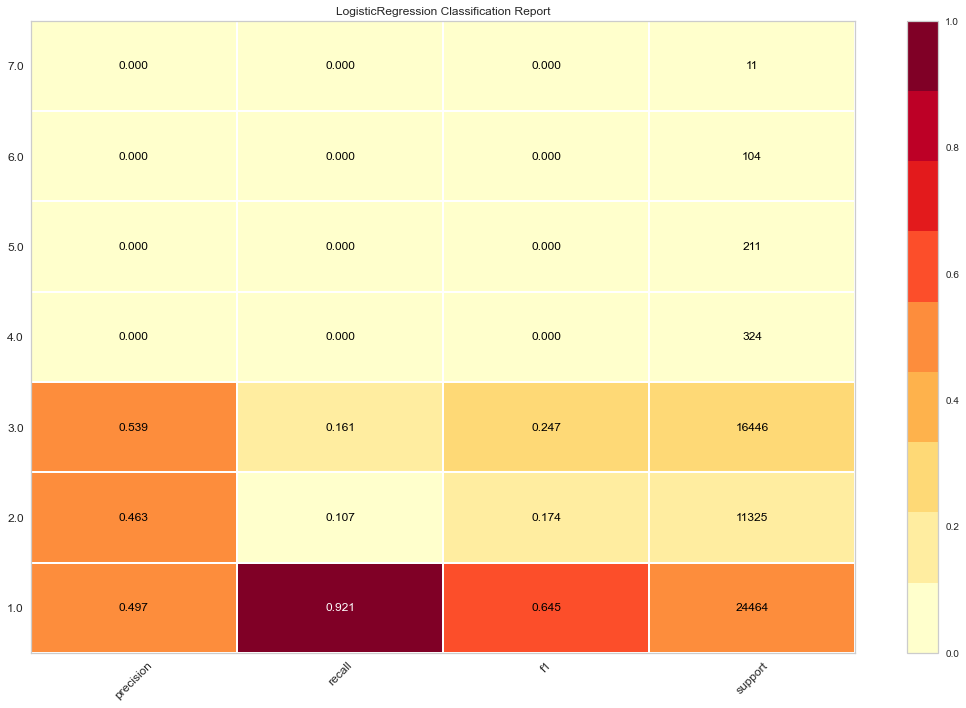

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [22]:
# Create a logistic regression

lg_model = LogisticRegression(solver='lbfgs',max_iter=100)
lg_mean_model = lg_model.fit(X_mean_train, y_mean_train)
y_lgmean_pred = lg_model.predict(X_mean_test)

lg_accuracy = accuracy_score(y_mean_test, y_lgmean_pred)
print(f"Accuracy Score with mean: {lg_accuracy}")
print("Classification Report fillna with mean")
print(classification_report(y_mean_test, y_lgmean_pred))

visualizer = ClassificationReport(
    lg_model, classes=lg_mean_model.classes_, support=True, size=(1080, 720)
)

visualizer.fit(X_mean_train, y_mean_train)  # Fit the visualizer and the model
visualizer.score(X_mean_test, y_mean_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

In [23]:
# Create a decision tree classifier
dt_model = DecisionTreeClassifier(random_state=0)
dt_mean_model = dt_model.fit(X_mean_train, y_mean_train)
y_dtmean_pred = dt_model.predict(X_mean_test)

dt_accuracy = accuracy_score(y_mean_test, y_dtmean_pred)
print(f"Accuracy Score with mean: {dt_accuracy}")
print("Classification Report fillna with mean")
print(classification_report(y_mean_test, y_dtmean_pred))

Accuracy Score with mean: 0.4979294696038574
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.50      0.91      0.64     24464
         2.0       0.45      0.12      0.19     11325
         3.0       0.54      0.16      0.25     16446
         4.0       0.00      0.00      0.00       324
         5.0       0.00      0.00      0.00       211
         6.0       0.00      0.00      0.00       104
         7.0       0.00      0.00      0.00        11

    accuracy                           0.50     52885
   macro avg       0.21      0.17      0.16     52885
weighted avg       0.49      0.50      0.42     52885



In [24]:
# Create a bagging classifier
from sklearn.ensemble import BaggingClassifier

b_model = BaggingClassifier(random_state=100)
b_mean_model = b_model.fit(X_mean_train, y_mean_train)
y_bmean_pred = b_model.predict(X_mean_test)

b_accuracy = accuracy_score(y_mean_test, y_bmean_pred)
print(f"Accuracy Score with mean: {b_accuracy}")
print("Classification Report fillna with mean")
print(classification_report(y_mean_test, y_bmean_pred))

Accuracy Score with mean: 0.49838328448520375
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.50      0.91      0.64     24464
         2.0       0.45      0.13      0.20     11325
         3.0       0.54      0.16      0.25     16446
         4.0       0.00      0.00      0.00       324
         5.0       0.33      0.00      0.01       211
         6.0       0.00      0.00      0.00       104
         7.0       0.00      0.00      0.00        11

    accuracy                           0.50     52885
   macro avg       0.26      0.17      0.16     52885
weighted avg       0.50      0.50      0.42     52885



In [25]:
# Conusion Matrix to predict fire severity base on DiscoveryAcres
predictions_mean = rf_mean_model.predict(X_mean_test)
cm_mean = confusion_matrix(y_mean_test, predictions_mean, labels=rf_mean_model.classes_)
# DataFrame from the confusion matrix.
cm_df_mean = pd.DataFrame(cm_mean, index=["Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                     columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
cm_df_mean

#Class 1 - one-quarter acre or less;
#Class 2 - more than one-quarter acre, but less than 10 acres;
#Class 3 - more than 10 acres, but less than 100 acres;
#Class 4 - more than 100 acres, but less than 300 acres;
#Class 5 - more than 300 acres, but less than 1000 acres;
#Class 6 - more than 1000 acres, but less than 5000 acres;
#Class 7 - 5000 acres or more.

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,22239,1169,1056,0,0,0,0
Class 2,8724,1384,1217,0,0,0,0
Class 3,13266,465,2715,0,0,0,0
Class 4,243,36,45,0,0,0,0
Class 5,163,18,30,0,0,0,0
Class 6,91,4,9,0,0,0,0
Class 7,10,1,0,0,0,0,0


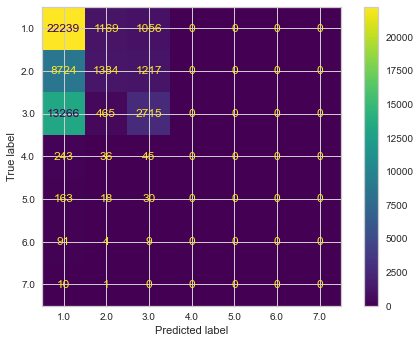

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mean, display_labels=rf_mean_model.classes_)
disp.plot()
plt.show()

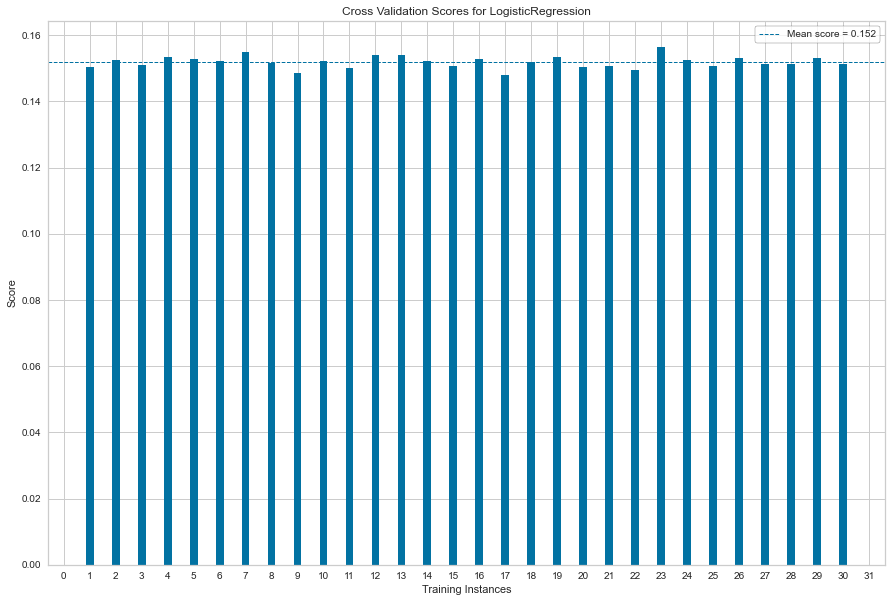

<AxesSubplot:title={'center':'Cross Validation Scores for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [27]:
from sklearn.model_selection import RepeatedStratifiedKFold
from yellowbrick.model_selection import CVScores

# Create a cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Instantiate the classification model and visualizer
model_lg = LogisticRegression(solver='lbfgs',max_iter=100)
visualizer = CVScores(
    model_lg, cv=cv, scoring='f1_macro', size=(1080, 720)
)

visualizer.fit(X_mean_train, y_mean_train)
visualizer.show()

In [28]:
# using SMOTE-ENN to balance the data

fires_smoteen_mean = fires_da_mean.drop(['CorrectControlDateTime','Fire_Duration','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','POOState','PredominantFuelModel','InitialLatitude','InitialLongitude','FireCauseGeneral','DiscoveryDate'], axis=1)
fires_smoteen_mean.head()

,DiscoveryAcres,YEAR,fueltype_num,fire_severity
0,20.000000,2020,3,3.0
1,0.100000,2020,42,1.0
2,50.000000,2017,42,3.0
3,21.396285,2019,42,3.0
4,21.396285,2016,42,3.0


In [29]:
x_mean_cols = [i for i in fires_smoteen_mean.columns if i not in ('fire_severity')]
X_mean = fires_smoteen_mean[x_mean_cols]
y_mean = fires_smoteen_mean['fire_severity']

In [30]:
X_mean_train, X_mean_test, y_mean_train, y_mean_test = train_test_split(X_mean, y_mean, random_state=1, stratify=y_mean)

In [31]:
#Using SMOTE-ENN to balance the data
from imblearn.combine import SMOTEENN

smoteenn = SMOTEENN(random_state=1)
X_mean_resampled, y_mean_resampled = smoteenn.fit_resample(X_mean_train, y_mean_train)
y_mean_resampled.value_counts()

4.0    72848
5.0    72848
6.0    72848
7.0    72848
3.0    72819
2.0    72762
1.0    72742
Name: fire_severity, dtype: int64

In [32]:
#Using SMOTE-ENN to balance the data with LogisticRegression

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

#Define model
model = LogisticRegression(solver='lbfgs',max_iter=100)

#Define SMOTE-ENN
resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))

#Define pipeline
pipeline=Pipeline(steps=[('r', resample), ('m', model)])

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X_mean, y_mean, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Mean Accuracy: 0.9122
Mean Precision: 0.9568
Mean Recall: 0.9520


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score with mean: 0.9599886546279663
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.92      1.00      0.96     24283
         2.0       1.00      0.82      0.90     11334
         3.0       1.00      1.00      1.00     16607
         4.0       0.96      1.00      0.98       321
         5.0       1.00      1.00      1.00       232
         6.0       1.00      1.00      1.00        95
         7.0       1.00      1.00      1.00        13

    accuracy                           0.96     52885
   macro avg       0.98      0.97      0.98     52885
weighted avg       0.96      0.96      0.96     52885



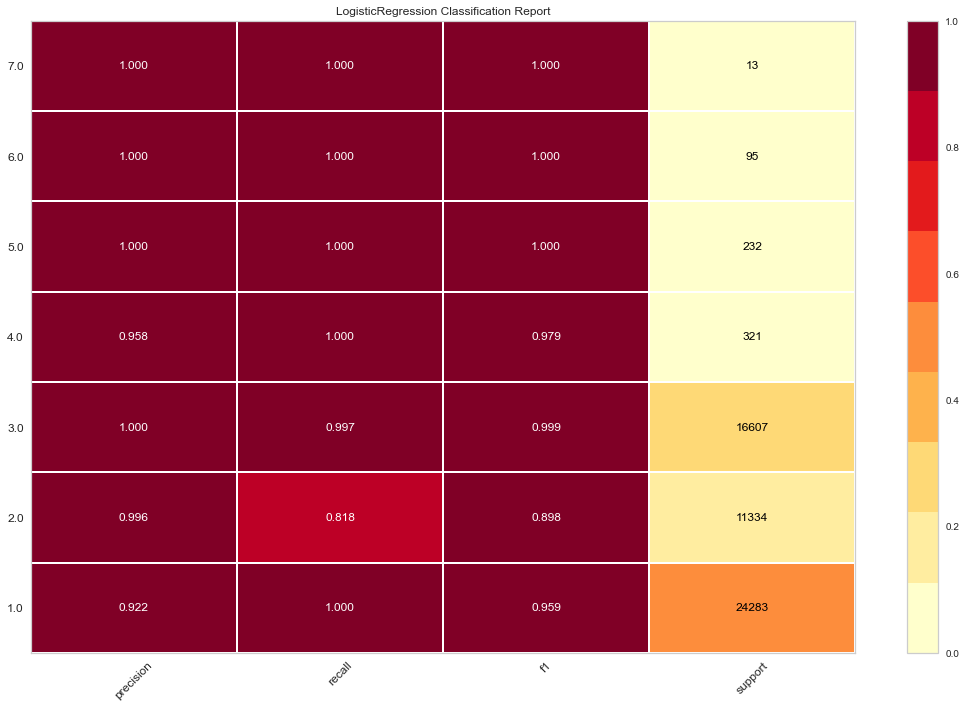

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [33]:
from sklearn.linear_model import LogisticRegression

lg_smoteen_model = LogisticRegression(solver='lbfgs',max_iter=100)
lg_smoteen_model.fit(X_mean_resampled, y_mean_resampled)
ys_lgmean_pred = lg_smoteen_model.predict(X_mean_test)

lg_smoteen_accuracy = accuracy_score(y_mean_test, ys_lgmean_pred)
print(f"Accuracy Score with mean: {lg_smoteen_accuracy}")
print("Classification Report fillna with mean")
print(classification_report(y_mean_test, ys_lgmean_pred))

visualizer = ClassificationReport(
    lg_smoteen_model, classes=lg_mean_model.classes_, support=True, size=(1080, 720)
)

visualizer.fit(X_mean_resampled, y_mean_resampled)  # Fit the visualizer and the model
visualizer.score(X_mean_test, y_mean_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data


In [34]:
#Using SMOTE-ENN to balance the data with RandomForest Classifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

#Define model
model = RandomForestClassifier()

#Define SMOTE-ENN
resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))

#Define pipeline
pipeline=Pipeline(steps=[('r', resample), ('m', model)])

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X_mean, y_mean, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

Mean Accuracy: 0.9999
Mean Precision: 0.9979
Mean Recall: 0.9914


Accuracy Score with mean: 0.9997541836059374
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     24283
         2.0       1.00      1.00      1.00     11334
         3.0       1.00      1.00      1.00     16607
         4.0       1.00      0.99      0.99       321
         5.0       0.98      1.00      0.99       232
         6.0       1.00      0.97      0.98        95
         7.0       1.00      1.00      1.00        13

    accuracy                           1.00     52885
   macro avg       1.00      0.99      1.00     52885
weighted avg       1.00      1.00      1.00     52885



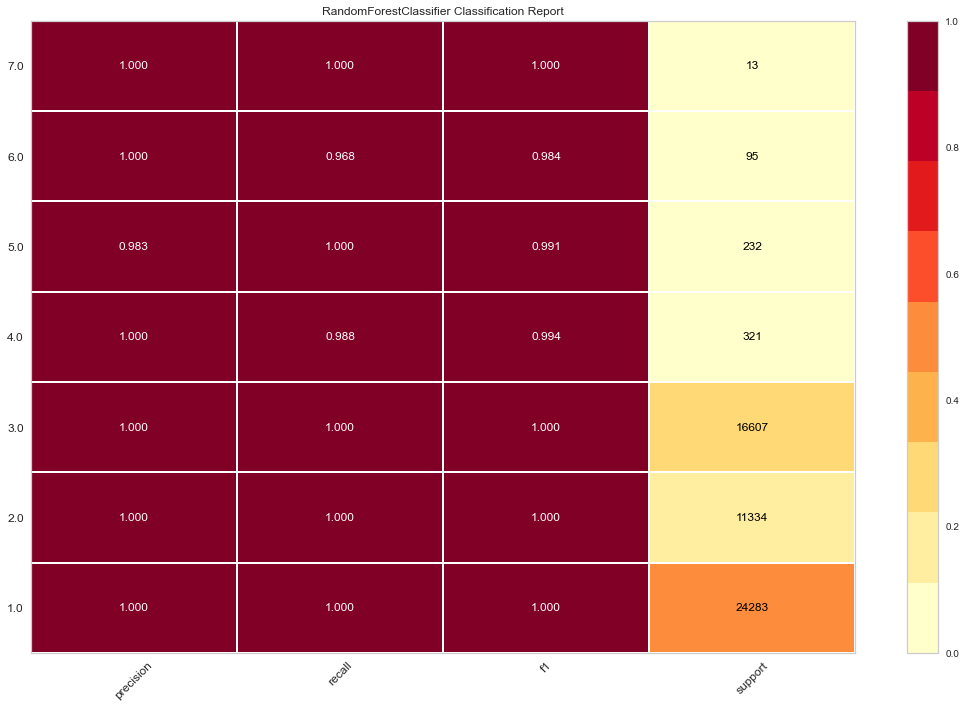

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [35]:
smoteen_rf_model = RandomForestClassifier()
smoteen_rf_model.fit(X_mean_resampled, y_mean_resampled)
y_rfmean_pred = smoteen_rf_model.predict(X_mean_test)

rf_smoteen_accuracy = accuracy_score(y_mean_test, y_rfmean_pred)
print(f"Accuracy Score with mean: {rf_smoteen_accuracy}")
print("Classification Report fillna with mean")
print(classification_report(y_mean_test, y_rfmean_pred))

visualizer = ClassificationReport(
    smoteen_rf_model, classes=smoteen_rf_model.classes_, support=True, size=(1080, 720)
)

visualizer.fit(X_mean_resampled, y_mean_resampled)  # Fit the visualizer and the model
visualizer.score(X_mean_test, y_mean_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data


# Fire Severity base on Discovery Acres (fill na with median value)

In [36]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires (fillna with min value)
fires_da_median.loc[fires_da_median['DiscoveryAcres'] <= .25, 'fire_severity'] = 1
fires_da_median.loc[(fires_da_median['DiscoveryAcres'] > .25) & (fires_da_median['DiscoveryAcres'] <= 10), 'fire_severity'] = 2
fires_da_median.loc[(fires_da_median['DiscoveryAcres'] > 10) & (fires_da_median['DiscoveryAcres'] <= 100), 'fire_severity'] = 3
fires_da_median.loc[(fires_da_median['DiscoveryAcres'] > 100) & (fires_da_median['DiscoveryAcres'] <= 300), 'fire_severity'] = 4
fires_da_median.loc[(fires_da_median['DiscoveryAcres'] > 300) & (fires_da_median['DiscoveryAcres'] <= 1000), 'fire_severity'] = 5
fires_da_median.loc[(fires_da_median['DiscoveryAcres'] > 1000) & (fires_da_median['DiscoveryAcres'] <= 5000), 'fire_severity'] = 6
fires_da_median.loc[fires_da_median['DiscoveryAcres'] > 5000, 'fire_severity'] = 7          
print(fires_da_median['fire_severity'].value_counts())

1.0    157013
2.0     45336
3.0      6545
4.0      1282
5.0       926
6.0       381
7.0        54
Name: fire_severity, dtype: int64


<AxesSubplot:title={'center':'Severity (class)'}>

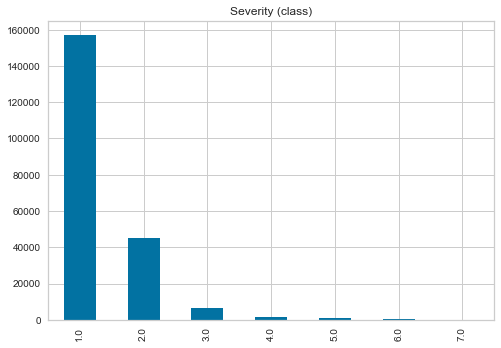

In [37]:
severity_count = fires_da_median.fire_severity.value_counts()
severity_count.plot(kind='bar', title='Severity (class)')

In [38]:
fires_binary_encoded_median = pd.get_dummies(fires_da_median, columns=["PredominantFuelModel", "FireCauseGeneral"])

fires_binary_encoded_median = fires_binary_encoded_median.drop(['fueltype_num','CorrectControlDateTime','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude','YEAR','DiscoveryDate','POOState','Fire_Duration'], axis=1)
fires_binary_encoded_median.head()

,fire_severity,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,...,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,3.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Define the features set.
X_median = fires_binary_encoded_median
X_median = X_median.drop(["fire_severity"], axis=1)
X_median.head()

,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,PredominantFuelModel_GS1,...,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
# Define the target set.
y_median = fires_binary_encoded_median["fire_severity"].ravel()
y_median[:5]

array([3., 1., 3., 1., 1.])

In [41]:
# Splitting into Train and Test sets.
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median, y_median, random_state=78)

In [42]:
#No Imbalance Handling with RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

#Define model
model_median = RandomForestClassifier()

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv_rm=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores_rm_median = cross_validate(model_median, X_median, y_median, scoring=scoring, cv=cv_rm, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_rm_median['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_rm_median['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_rm_median['test_recall_macro']))


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedM

Mean Accuracy: 0.7444
Mean Precision: 0.2522
Mean Recall: 0.1497


Accuracy Score with mean: 0.7475843812045003
RandomForestClassification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.75      0.99      0.85     39431
         2.0       0.50      0.05      0.10     11148
         3.0       0.43      0.00      0.01      1635
         4.0       0.00      0.00      0.00       329
         5.0       0.00      0.00      0.00       243
         6.0       0.00      0.00      0.00        87
         7.0       0.00      0.00      0.00        12

    accuracy                           0.75     52885
   macro avg       0.24      0.15      0.14     52885
weighted avg       0.68      0.75      0.66     52885



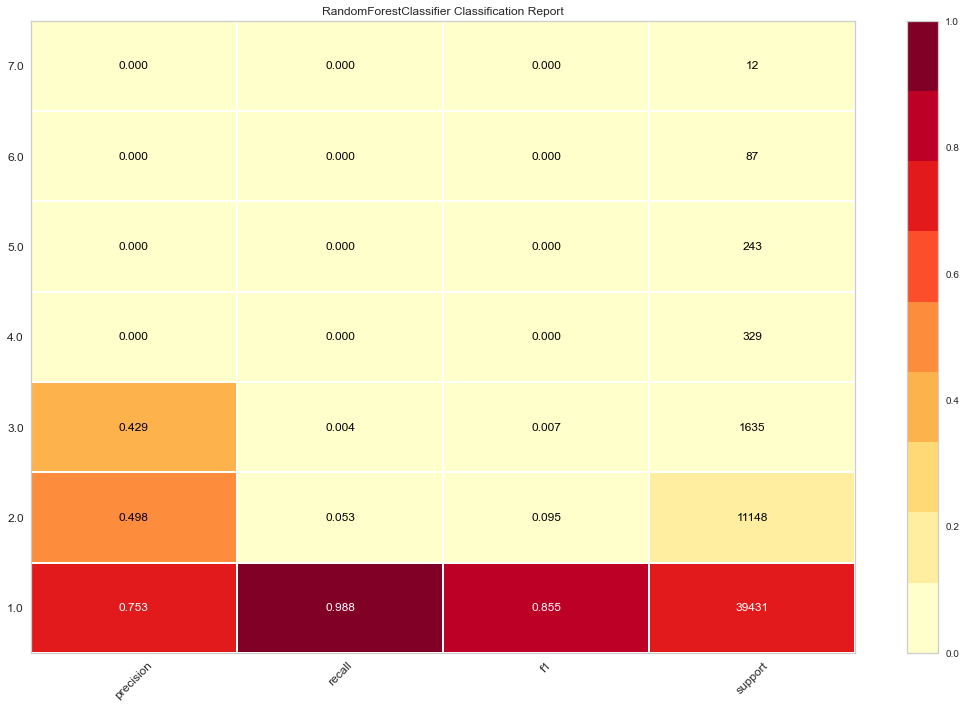

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [43]:
from yellowbrick.classifier import ClassificationReport

# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=0) 

# Fitting the model
rf_median_model = rf_model.fit(X_median_train, y_median_train)
y_rfmedian_pred = rf_model.predict(X_median_test)

rf_accuracy = accuracy_score(y_median_test, y_rfmedian_pred)
print(f"Accuracy Score with mean: {rf_accuracy}")
print("RandomForestClassification Report fillna with mean")
print(classification_report(y_median_test, y_rfmedian_pred))

visualizer = ClassificationReport(
    rf_model, classes=rf_median_model.classes_, support=True, size=(1080, 720)
)

visualizer.fit(X_median_train, y_median_train)  # Fit the visualizer and the model
visualizer.score(X_median_test, y_median_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

In [44]:
##No Imbalance Handling with LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score


#Define model
model_ori = LogisticRegression(solver='lbfgs',max_iter=100)

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv_lg=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores_lg_median = cross_validate(model_ori, X_median, y_median, scoring=scoring, cv=cv_lg, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_lg_median['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_lg_median['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_lg_median['test_recall_macro']))


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Mean Accuracy: 0.7440
Mean Precision: 0.1785
Mean Recall: 0.1486


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score with mean: 0.7477167438782263
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.75      0.99      0.85     39431
         2.0       0.51      0.05      0.10     11148
         3.0       0.00      0.00      0.00      1635
         4.0       0.00      0.00      0.00       329
         5.0       0.00      0.00      0.00       243
         6.0       0.00      0.00      0.00        87
         7.0       0.00      0.00      0.00        12

    accuracy                           0.75     52885
   macro avg       0.18      0.15      0.14     52885
weighted avg       0.67      0.75      0.66     52885



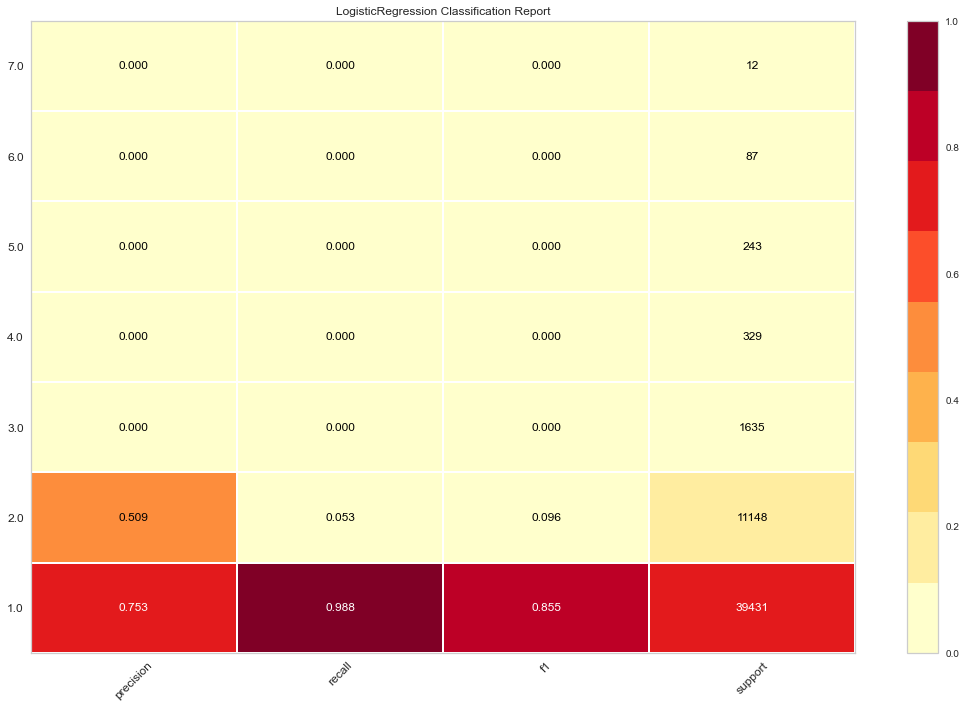

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [45]:
# Create a logistic regression

lg_model = LogisticRegression(solver='lbfgs',max_iter=100)
lg_median_model = lg_model.fit(X_median_train, y_median_train)
y_lgmedian_pred = lg_model.predict(X_median_test)

lg_accuracy = accuracy_score(y_median_test, y_lgmedian_pred)
print(f"Accuracy Score with mean: {lg_accuracy}")
print("Classification Report fillna with mean")
print(classification_report(y_median_test, y_lgmedian_pred))

visualizer = ClassificationReport(
    lg_model, classes=lg_median_model.classes_, support=True, size=(1080, 720)
)

visualizer.fit(X_median_train, y_median_train)  # Fit the visualizer and the model
visualizer.score(X_median_test, y_median_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

In [46]:
# Conusion Matrix to predict fire severity base on DiscoveryAcres
predictions_median = rf_median_model.predict(X_median_test)
cm_median = confusion_matrix(y_median_test, predictions_median, labels=rf_median_model.classes_)
# DataFrame from the confusion matrix.
cm_df_median = pd.DataFrame(cm_median, index=["Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                         columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
cm_df_median

#Class 1 - one-quarter acre or less;
#Class 2 - more than one-quarter acre, but less than 10 acres;
#Class 3 - more than 10 acres, but less than 100 acres;
#Class 4 - more than 100 acres, but less than 300 acres;
#Class 5 - more than 300 acres, but less than 1000 acres;
#Class 6 - more than 1000 acres, but less than 5000 acres;
#Class 7 - 5000 acres or more.

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,38944,483,3,0,1,0,0
Class 2,10558,586,2,1,1,0,0
Class 3,1541,88,6,0,0,0,0
Class 4,316,13,0,0,0,0,0
Class 5,234,5,3,1,0,0,0
Class 6,85,2,0,0,0,0,0
Class 7,12,0,0,0,0,0,0


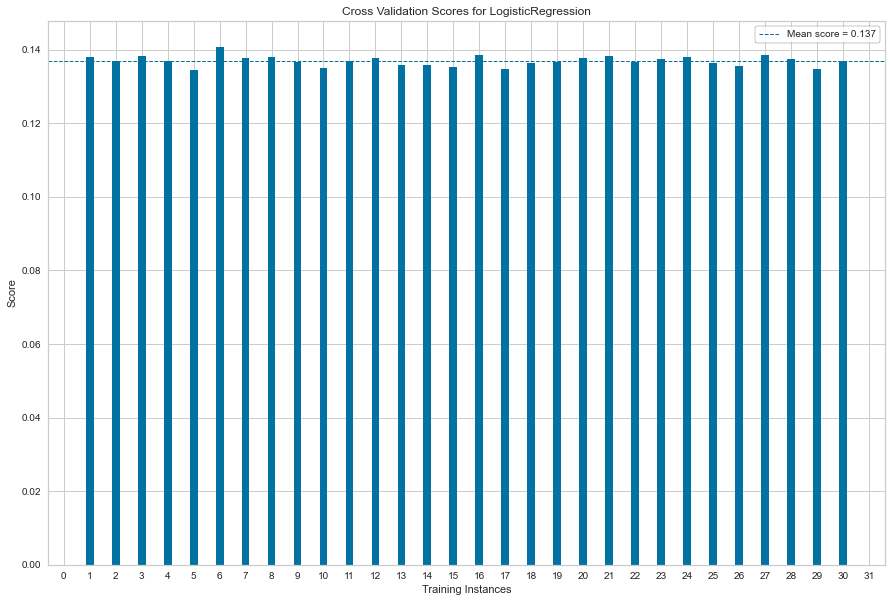

<AxesSubplot:title={'center':'Cross Validation Scores for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [47]:
# Create a cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Instantiate the classification model and visualizer
model_lg = LogisticRegression(solver='lbfgs',max_iter=100)
visualizer = CVScores(
    model_lg, cv=cv, scoring='f1_macro', size=(1080, 720)
)

visualizer.fit(X_median_train, y_median_train)
visualizer.show()

In [48]:
#Using SMOTE-ENN to balance the data
from imblearn.combine import SMOTEENN

fires_smoteen_median = fires_da_median.drop(['CorrectControlDateTime','Fire_Duration','ControlDateTime','ContainmentDateTime','DailyAcres','FireDiscoveryDateTime','POOState','PredominantFuelModel','InitialLatitude','InitialLongitude','FireCauseGeneral','DiscoveryDate'], axis=1)
fires_smoteen_median.head()

,DiscoveryAcres,YEAR,fueltype_num,fire_severity
0,20.0,2020,3,3.0
1,0.1,2020,42,1.0
2,50.0,2017,42,3.0
3,0.1,2019,42,1.0
4,0.1,2016,42,1.0


In [49]:
x_median_cols = [i for i in fires_smoteen_median.columns if i not in ('fire_severity')]
X_median = fires_smoteen_median[x_median_cols]
y_median = fires_smoteen_median['fire_severity']

In [50]:
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median, y_median, random_state=1, stratify=y_median)

In [51]:
smoteenn = SMOTEENN(random_state=1)
X_median_resampled, y_median_resampled = smoteenn.fit_resample(X_median_train, y_median_train)
y_median_resampled.value_counts()

3.0    117759
4.0    117759
5.0    117759
6.0    117759
7.0    117759
2.0    117700
1.0    117641
Name: fire_severity, dtype: int64

In [52]:
#Using SMOTE-ENN to balance the data with LogisticRegression

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

#Define model
model = LogisticRegression(solver='lbfgs',max_iter=100)

#Define SMOTE-ENN
resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))

#Define pipeline
pipeline=Pipeline(steps=[('r', resample), ('m', model)])

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X_median, y_median, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Mean Accuracy: 0.9270
Mean Precision: 0.9659
Mean Recall: 0.9655


Accuracy Score with mean: 0.9350477451073083
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96     39254
         2.0       0.86      0.83      0.85     11334
         3.0       0.98      1.00      0.99      1636
         4.0       1.00      1.00      1.00       321
         5.0       1.00      1.00      1.00       232
         6.0       1.00      1.00      1.00        95
         7.0       1.00      1.00      1.00        13

    accuracy                           0.94     52885
   macro avg       0.97      0.97      0.97     52885
weighted avg       0.93      0.94      0.93     52885



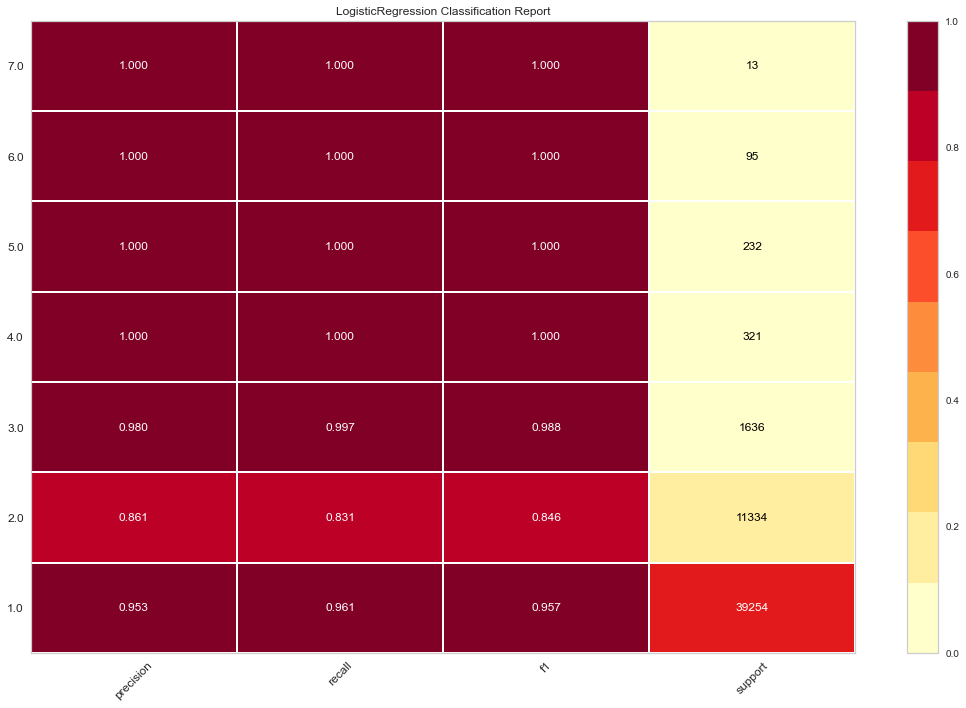

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [53]:
from sklearn.linear_model import LogisticRegression

lg_smoteen_model = LogisticRegression(solver='lbfgs',max_iter=100)
lg_smoteen_model.fit(X_median_resampled, y_median_resampled)
ys_lgmedian_pred = lg_smoteen_model.predict(X_median_test)

lg_smoteen_accuracy = accuracy_score(y_median_test, ys_lgmedian_pred)
print(f"Accuracy Score with mean: {lg_smoteen_accuracy}")
print("Classification Report fillna with mean")
print(classification_report(y_median_test, ys_lgmedian_pred))

visualizer = ClassificationReport(
    lg_smoteen_model, classes=lg_median_model.classes_, support=True, size=(1080, 720)
)

visualizer.fit(X_median_resampled, y_median_resampled)  # Fit the visualizer and the model
visualizer.score(X_median_test, y_median_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data


In [54]:
##Using SMOTE-ENN to balance the data with RandomForest Classifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

#Define model
model = RandomForestClassifier()

#Define SMOTE-ENN
resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))

#Define pipeline
pipeline=Pipeline(steps=[('r', resample), ('m', model)])

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X_median, y_median, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

Mean Accuracy: 0.9999
Mean Precision: 0.9970
Mean Recall: 0.9880


Accuracy Score with mean: 0.9998487283728845
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     39254
         2.0       1.00      1.00      1.00     11334
         3.0       1.00      1.00      1.00      1636
         4.0       1.00      1.00      1.00       321
         5.0       1.00      1.00      1.00       232
         6.0       0.98      0.99      0.98        95
         7.0       1.00      0.85      0.92        13

    accuracy                           1.00     52885
   macro avg       1.00      0.98      0.99     52885
weighted avg       1.00      1.00      1.00     52885



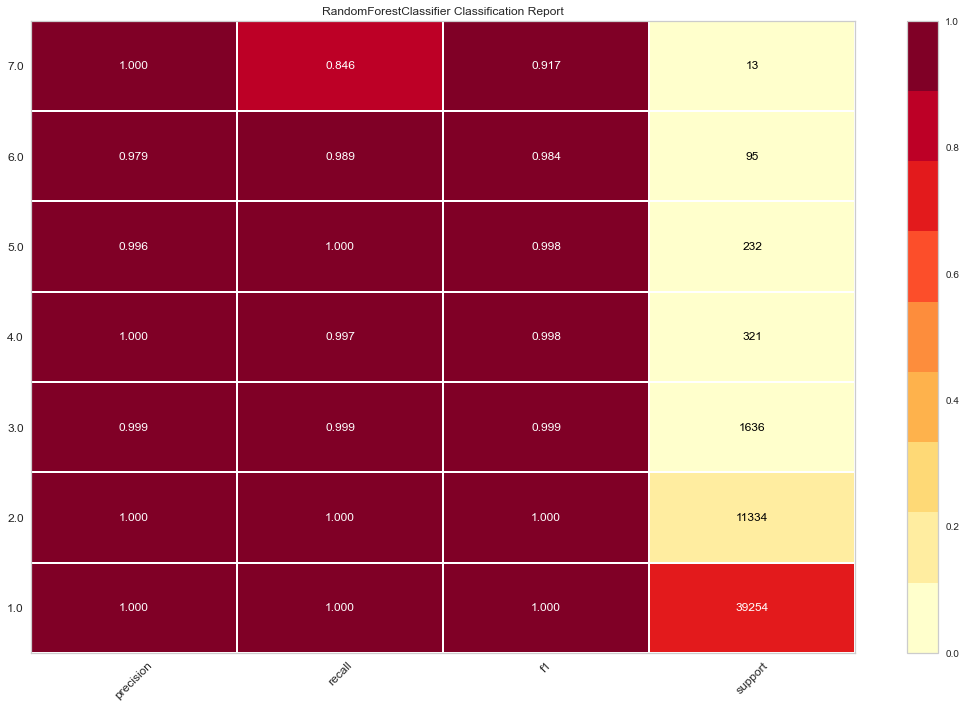

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [55]:
smoteen_rf_model = RandomForestClassifier()
smoteen_rf_model.fit(X_median_resampled, y_median_resampled)
y_rfmedian_pred = smoteen_rf_model.predict(X_median_test)

rf_smoteen_accuracy = accuracy_score(y_median_test, y_rfmedian_pred)
print(f"Accuracy Score with mean: {rf_smoteen_accuracy}")
print("Classification Report fillna with mean")
print(classification_report(y_median_test, y_rfmedian_pred))

visualizer = ClassificationReport(
    smoteen_rf_model, classes=smoteen_rf_model.classes_, support=True, size=(1080, 720)
)

visualizer.fit(X_median_resampled, y_median_resampled)  # Fit the visualizer and the model
visualizer.score(X_median_test, y_median_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data


# Fire Severity base on Discovery Acres (dropna value)

In [56]:
# Set and Classify Fire Sizes - https://www.nwcg.gov/term/glossary/size-class-of-fire
# Smaller buckets were used to better handle the skew in small fires vs large fires (drop nan value)
fires_da_drop.loc[fires_da_drop['DiscoveryAcres'] <= .25, 'fire_severity'] = 1
fires_da_drop.loc[(fires_da_drop['DiscoveryAcres'] > .25) & (fires_da_drop['DiscoveryAcres'] <= 10), 'fire_severity'] = 2
fires_da_drop.loc[(fires_da_drop['DiscoveryAcres'] > 10) & (fires_da_drop['DiscoveryAcres'] <= 100), 'fire_severity'] = 3
fires_da_drop.loc[(fires_da_drop['DiscoveryAcres'] > 100) & (fires_da_drop['DiscoveryAcres'] <= 300), 'fire_severity'] = 4
fires_da_drop.loc[(fires_da_drop['DiscoveryAcres'] > 300) & (fires_da_drop['DiscoveryAcres'] <= 1000), 'fire_severity'] = 5
fires_da_drop.loc[(fires_da_drop['DiscoveryAcres'] > 1000) & (fires_da_drop['DiscoveryAcres'] <= 5000), 'fire_severity'] = 6
fires_da_drop.loc[fires_da_drop['DiscoveryAcres'] > 5000, 'fire_severity'] = 7          
print(fires_da_drop['fire_severity'].value_counts())

1.0    97131
2.0    45336
3.0     6545
4.0     1282
5.0      926
6.0      381
7.0       54
Name: fire_severity, dtype: int64


<AxesSubplot:title={'center':'Severity (class)'}>

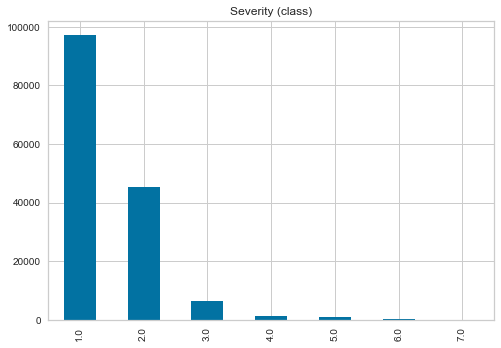

In [57]:
severity_count = fires_da_drop.fire_severity.value_counts()
severity_count.plot(kind='bar', title='Severity (class)')

In [58]:
fires_binary_encoded_drop = pd.get_dummies(fires_da_drop, columns=["PredominantFuelModel", "FireCauseGeneral"])

fires_binary_encoded_drop = fires_binary_encoded_drop.drop(['fueltype_num','CorrectControlDateTime','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','DiscoveryAcres','InitialLatitude','InitialLongitude','YEAR','DiscoveryDate','POOState','Fire_Duration'], axis=1)
fires_binary_encoded_drop.head()

,fire_severity,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,...,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,3.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# Define the features set.
X_drop = fires_binary_encoded_drop
X_drop = X_drop.drop(["fire_severity"], axis=1)
X_drop.head()

,PredominantFuelModel_GR1,PredominantFuelModel_GR2,PredominantFuelModel_GR3,PredominantFuelModel_GR4,PredominantFuelModel_GR5,PredominantFuelModel_GR6,PredominantFuelModel_GR7,PredominantFuelModel_GR8,PredominantFuelModel_GR9,PredominantFuelModel_GS1,...,PredominantFuelModel_TL8,PredominantFuelModel_TL9,PredominantFuelModel_TU1,PredominantFuelModel_TU2,PredominantFuelModel_TU3,PredominantFuelModel_TU4,PredominantFuelModel_TU5,FireCauseGeneral_1,FireCauseGeneral_2,FireCauseGeneral_3
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# Define the target set.
y_drop = fires_binary_encoded_drop["fire_severity"].ravel()
y_drop[:5]

array([3., 1., 3., 2., 1.])

In [61]:
# Splitting into Train and Test sets.
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, random_state=78)

In [62]:
#No Imbalance Handling with RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

#Define model
model_drop = RandomForestClassifier()

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv_rm=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores_rm_drop = cross_validate(model_drop, X_drop, y_drop, scoring=scoring, cv=cv_rm, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_rm_drop['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_rm_drop['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_rm_drop['test_recall_macro']))


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedM

Mean Accuracy: 0.6536
Mean Precision: 0.2472
Mean Recall: 0.1636


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score with mean: 0.6537426808039247
RandomForestClassification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.67      0.93      0.78     24151
         2.0       0.51      0.21      0.30     11483
         3.0       0.62      0.00      0.01      1682
         4.0       0.00      0.00      0.00       276
         5.0       0.00      0.00      0.00       207
         6.0       0.00      0.00      0.00        96
         7.0       0.00      0.00      0.00        19

    accuracy                           0.65     37914
   macro avg       0.26      0.16      0.16     37914
weighted avg       0.61      0.65      0.59     37914



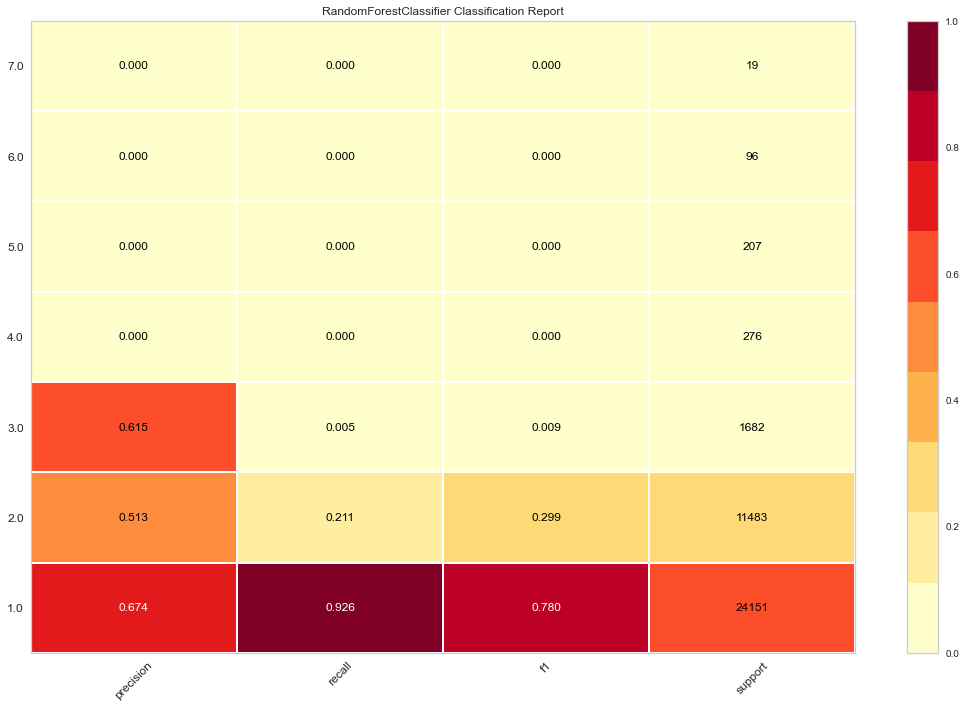

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [63]:
from yellowbrick.classifier import ClassificationReport

# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=0) 

# Fitting the model
rf_drop_model = rf_model.fit(X_drop_train, y_drop_train)
y_rfdrop_pred = rf_model.predict(X_drop_test)

rf_accuracy = accuracy_score(y_drop_test, y_rfdrop_pred)
print(f"Accuracy Score with mean: {rf_accuracy}")
print("RandomForestClassification Report fillna with mean")
print(classification_report(y_drop_test, y_rfdrop_pred))

visualizer = ClassificationReport(
    rf_model, classes=rf_drop_model.classes_, support=True, size=(1080, 720)
)

visualizer.fit(X_drop_train, y_drop_train)  # Fit the visualizer and the model
visualizer.score(X_drop_test, y_drop_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

In [64]:
##No Imbalance Handling with LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score


#Define model
model_ori = LogisticRegression(solver='lbfgs',max_iter=100)

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv_lg=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores_lg_drop = cross_validate(model_ori, X_drop, y_drop, scoring=scoring, cv=cv_lg, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_lg_drop['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_lg_drop['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_lg_drop['test_recall_macro']))


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.


Mean Accuracy: 0.6531
Mean Precision: 0.1672
Mean Recall: 0.1616


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy Score with mean: 0.6531360447328164
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.67      0.93      0.78     24151
         2.0       0.51      0.20      0.29     11483
         3.0       0.00      0.00      0.00      1682
         4.0       0.00      0.00      0.00       276
         5.0       0.00      0.00      0.00       207
         6.0       0.00      0.00      0.00        96
         7.0       0.00      0.00      0.00        19

    accuracy                           0.65     37914
   macro avg       0.17      0.16      0.15     37914
weighted avg       0.58      0.65      0.58     37914



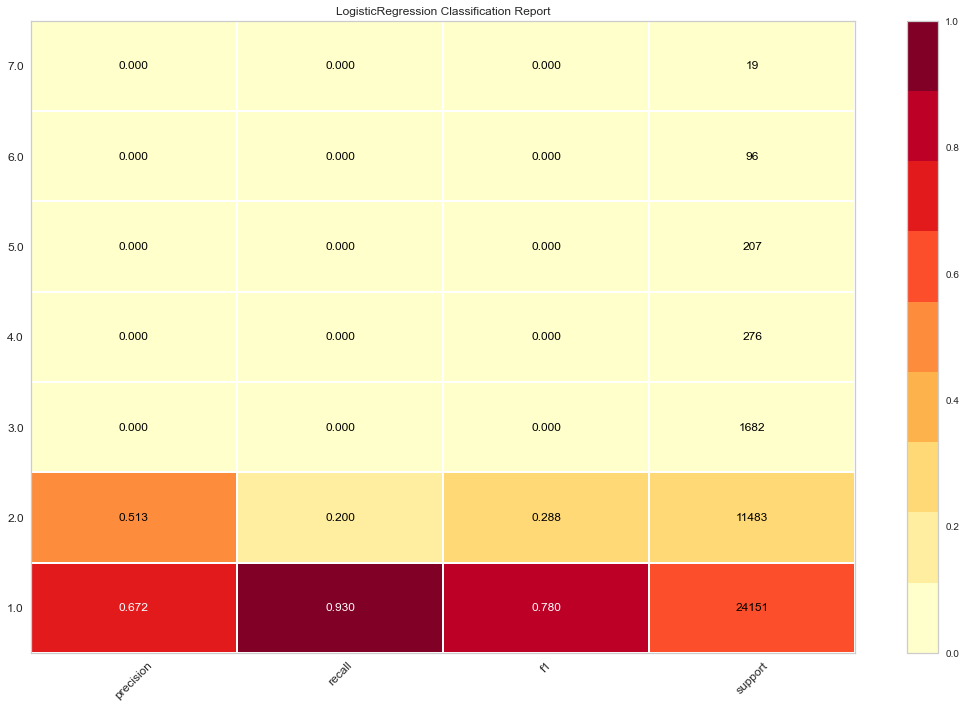

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [65]:
# Create a logistic regression

lg_model = LogisticRegression(solver='lbfgs',max_iter=100)
lg_drop_model = lg_model.fit(X_drop_train, y_drop_train)
y_lgdrop_pred = lg_model.predict(X_drop_test)

lg_accuracy = accuracy_score(y_drop_test, y_lgdrop_pred)
print(f"Accuracy Score with mean: {lg_accuracy}")
print("Classification Report fillna with mean")
print(classification_report(y_drop_test, y_lgdrop_pred))

visualizer = ClassificationReport(
    lg_model, classes=lg_drop_model.classes_, support=True, size=(1080, 720)
)

visualizer.fit(X_drop_train, y_drop_train)  # Fit the visualizer and the model
visualizer.score(X_drop_test, y_drop_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

In [68]:
predictions_drop = rf_drop_model.predict(X_drop_test)

# Conusion Matrix to predict fire severity base on DiscoveryAcres
cm_drop = confusion_matrix(y_drop_test, predictions_drop)
# DataFrame from the confusion matrix.
cm_df_drop = pd.DataFrame(cm_drop, index=["Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7"], 
                          columns=["Predicted 1", "Predicted 2","Predicted 3","Predicted 4","Predicted 5","Predicted 6","Predicted 7"])
cm_df_drop

#Class 1 - one-quarter acre or less;
#Class 2 - more than one-quarter acre, but less than 10 acres;
#Class 3 - more than 10 acres, but less than 100 acres;
#Class 4 - more than 100 acres, but less than 300 acres;
#Class 5 - more than 300 acres, but less than 1000 acres;
#Class 6 - more than 1000 acres, but less than 5000 acres;
#Class 7 - 5000 acres or more.

,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7
Class 1,22357,1791,2,0,1,0,0
Class 2,9058,2421,3,0,1,0,0
Class 3,1285,386,8,1,2,0,0
Class 4,220,56,0,0,0,0,0
Class 5,159,48,0,0,0,0,0
Class 6,83,13,0,0,0,0,0
Class 7,13,6,0,0,0,0,0


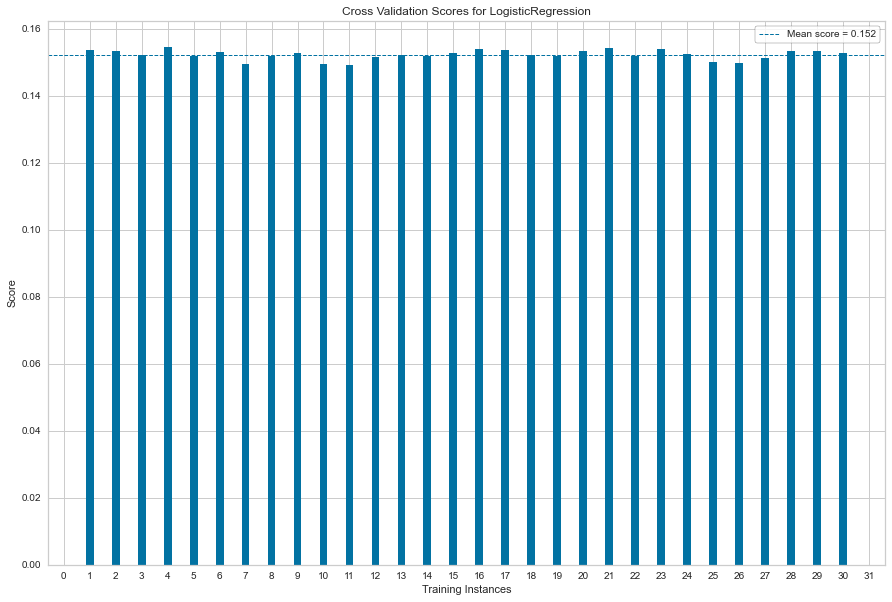

<AxesSubplot:title={'center':'Cross Validation Scores for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [69]:
# Create a cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Instantiate the classification model and visualizer
model_lg = LogisticRegression(solver='lbfgs',max_iter=100)
visualizer = CVScores(
    model_lg, cv=cv, scoring='f1_macro', size=(1080, 720)
)

visualizer.fit(X_drop_train, y_drop_train)
visualizer.show()

In [70]:
from imblearn.combine import SMOTEENN

fires_smoteen_drop = fires_da_drop.drop(['CorrectControlDateTime','Fire_Duration','ControlDateTime','ContainmentDateTime','FireDiscoveryDateTime','DailyAcres','POOState','PredominantFuelModel','InitialLatitude','InitialLongitude','FireCauseGeneral','DiscoveryDate'], axis=1)
fires_smoteen_drop.head()

,DiscoveryAcres,YEAR,fueltype_num,fire_severity
0,20.0,2020,3,3.0
1,0.1,2020,42,1.0
2,50.0,2017,42,3.0
5,1.0,2020,26,2.0
6,0.1,2019,42,1.0


In [71]:
x_drop_cols = [i for i in fires_smoteen_drop.columns if i not in ('fire_severity')]
X_drop = fires_smoteen_drop[x_drop_cols]
y_drop = fires_smoteen_drop['fire_severity']

In [72]:
X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, random_state=1, stratify=y_drop)

In [75]:
smoteenn = SMOTEENN(random_state=1)
X_drop_resampled, y_drop_resampled = smoteenn.fit_resample(X_drop_train, y_drop_train)
y_drop_resampled.value_counts()

4.0    72848
5.0    72848
6.0    72848
7.0    72848
3.0    72841
2.0    72768
1.0    72741
Name: fire_severity, dtype: int64

In [76]:
#Using SMOTE-ENN to balance the data with LogisticRegression

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

#Define model
model = LogisticRegression(solver='lbfgs',max_iter=100)

#Define SMOTE-ENN
resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))

#Define pipeline
pipeline=Pipeline(steps=[('r', resample), ('m', model)])

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X_drop, y_drop, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Mean Accuracy: 0.9095
Mean Precision: 0.9694
Mean Recall: 0.9649


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score with mean: 0.9020150867753336
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       0.92      0.93      0.92     24283
         2.0       0.85      0.82      0.83     11334
         3.0       1.00      1.00      1.00      1636
         4.0       1.00      1.00      1.00       321
         5.0       1.00      1.00      1.00       232
         6.0       1.00      1.00      1.00        95
         7.0       1.00      1.00      1.00        13

    accuracy                           0.90     37914
   macro avg       0.97      0.96      0.97     37914
weighted avg       0.90      0.90      0.90     37914



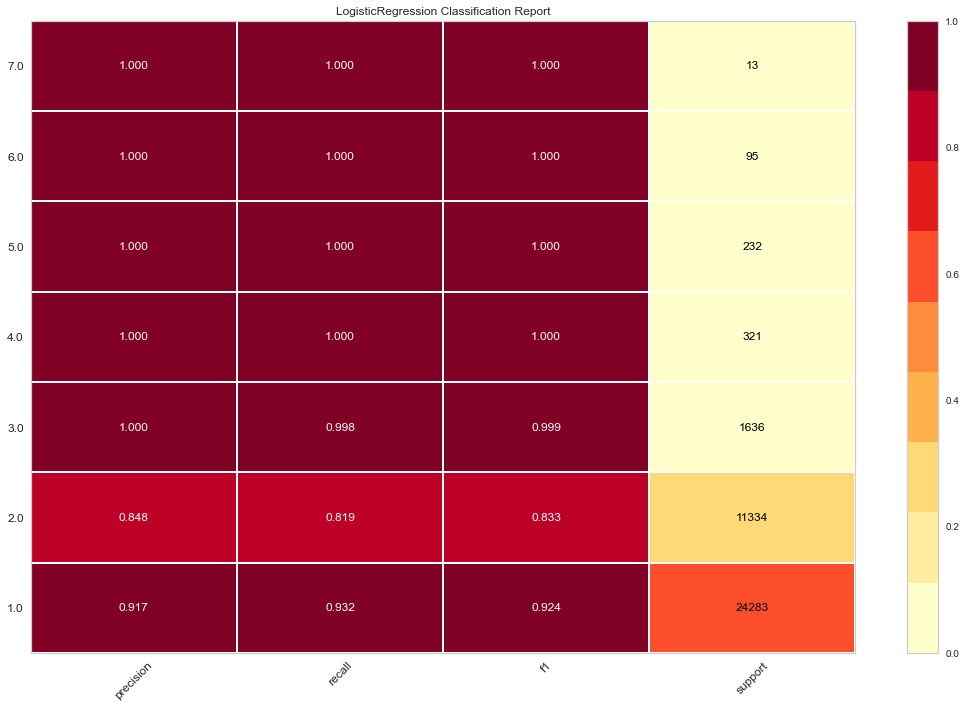

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [78]:
from sklearn.linear_model import LogisticRegression

lg_smoteen_model = LogisticRegression(solver='lbfgs',max_iter=100)
lg_smoteen_model.fit(X_drop_resampled, y_drop_resampled)
ys_lgdrop_pred = lg_smoteen_model.predict(X_drop_test)

lg_smoteen_accuracy = accuracy_score(y_drop_test, ys_lgdrop_pred)
print(f"Accuracy Score with mean: {lg_smoteen_accuracy}")
print("Classification Report fillna with mean")
print(classification_report(y_drop_test, ys_lgdrop_pred))

visualizer = ClassificationReport(
    lg_smoteen_model, classes=lg_drop_model.classes_, support=True, size=(1080, 720)
)

visualizer.fit(X_drop_resampled, y_drop_resampled)  # Fit the visualizer and the model
visualizer.score(X_drop_test, y_drop_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data


In [79]:
##Using SMOTE-ENN to balance the data with RandomForest Classifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

#Define model
model = RandomForestClassifier()

#Define SMOTE-ENN
resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))

#Define pipeline
pipeline=Pipeline(steps=[('r', resample), ('m', model)])

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X_drop, y_drop, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores['test_recall_macro']))

Mean Accuracy: 0.9998
Mean Precision: 0.9959
Mean Recall: 0.9873


Accuracy Score with mean: 0.9996834942237696
Classification Report fillna with mean
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00     24283
         2.0       1.00      1.00      1.00     11334
         3.0       1.00      1.00      1.00      1636
         4.0       1.00      0.99      1.00       321
         5.0       0.99      1.00      0.99       232
         6.0       0.98      0.99      0.98        95
         7.0       1.00      0.85      0.92        13

    accuracy                           1.00     37914
   macro avg       1.00      0.97      0.98     37914
weighted avg       1.00      1.00      1.00     37914



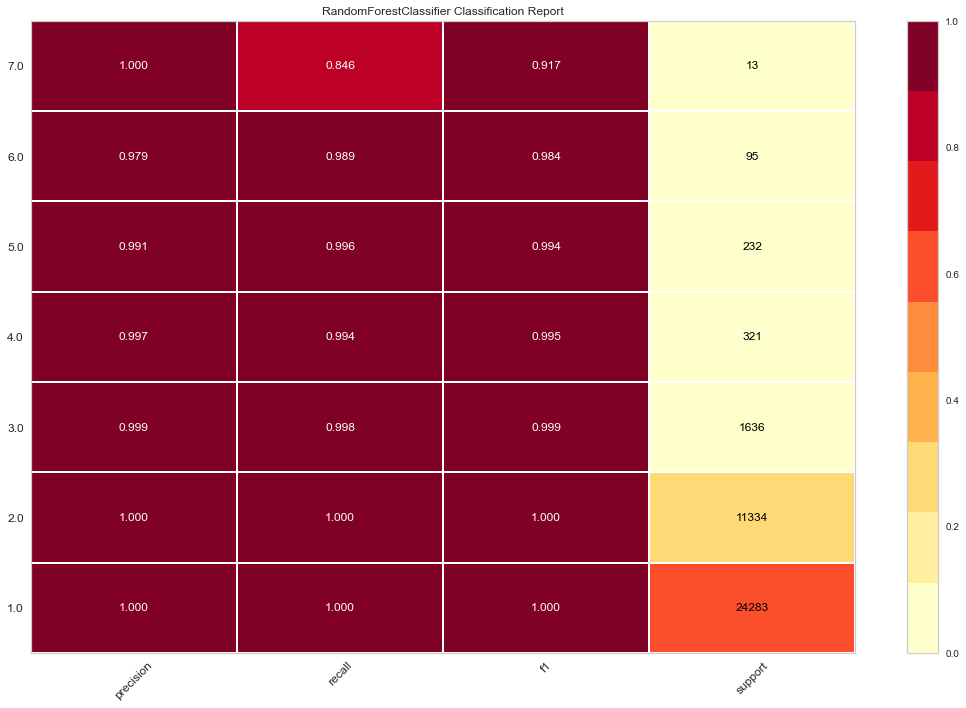

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [80]:
smoteen_rf_model = RandomForestClassifier()
smoteen_rf_model.fit(X_drop_resampled, y_drop_resampled)
y_rfdrop_pred = smoteen_rf_model.predict(X_drop_test)

rf_smoteen_accuracy = accuracy_score(y_drop_test, y_rfdrop_pred)
print(f"Accuracy Score with mean: {rf_smoteen_accuracy}")
print("Classification Report fillna with mean")
print(classification_report(y_drop_test, y_rfdrop_pred))

visualizer = ClassificationReport(
    smoteen_rf_model, classes=smoteen_rf_model.classes_, support=True, size=(1080, 720)
)

visualizer.fit(X_drop_resampled, y_drop_resampled)  # Fit the visualizer and the model
visualizer.score(X_drop_test, y_drop_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data
